## Transformer Demo: Sorting Cards

In this notebook we demonstrate transformers used for a translation, or seq2seq task, where the model learns to sort playing cards. The sorted order uses suit as the primary key: Diamonds, Clubs, Hearts, Spades. The secondary key is the value of the card: 2, 3, 4, 5, 6, 7, 8, 9, 10, Jack, Queen, King, Ace. This gives a vocabulary of size 52, but the model doesn't know anything about the values/suit on the card; it needs to learn to sort through examples, encoding the information implicitly in the embeddings. A 7-card hand and it's sorted arrangement looks like this:


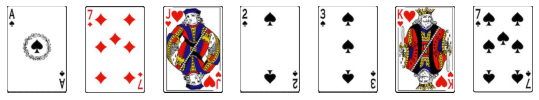

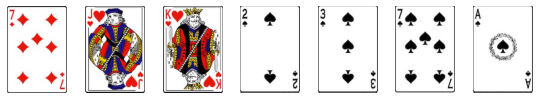

In [1]:
#!pip install pydealer
from hand2hand import Cards
import pydealer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

deck = Cards()
pydeck = pydealer.Deck()
pydeck.shuffle()
hand = pydeck.deal(7)
deck.show_pyhand(hand)
deck.sort_pyhand(hand)
deck.show_pyhand(hand)


Our implementation of transformers for seq2seq follows this description: [Neural Translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer). We've coded stuff for working with playing cards on top of the Python package `pydealer` that you will need to install. This is the file `hand2hand.py`. Then, we've implemented the seq2seq model with transformers from the above TensorFlow documentation. This is in the file `seq2seq_transformer.py`.  (You may need to upgrade your tensorflow installation to version 2.11.)

## Warmup: Is it sorted?

We'll begin by just training a classifier based on a transformer, to determine whether or not a hand of cards is sorted. To do this, we'll use an `Encoder` to represent the sequence, and then train a logistic regression model on top of this to do the classification. The whole thing is trained end-to-end. The `Encoder` uses a series of `EncoderLayer` modules, which looks like red box in this diagram:

![Encoder](https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png)

So, the `Encoder` first embeds the sequence with embedding and positional encoding, and then makes a series of 
transformations that compose multihead attention with feedforward layers (with normalization in between). The code below implements a classifier on top of this.

In [2]:
import tensorflow as tf
import seq2seq_transformer
from seq2seq_transformer import TokenAndPositionEmbedding, TokenEmbedding, TransformerBlock
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model

In [3]:
from seq2seq_transformer import Encoder

class HandClassifier():
    def __init__(self, n, embed_dim=32, num_layers=4, num_heads=8, ff_dim1=128, ff_dim2=32):
        vocab_size=52
        self.embed_dim = embed_dim
        attr_input = layers.Input(shape=(n,))
        x = Encoder(num_layers=num_layers, d_model=embed_dim, num_heads=num_heads, 
                    dff=ff_dim1, vocab_size=vocab_size)(attr_input)
        model_out = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(ff_dim2, activation='relu')(model_out) 
        outputs = layers.Dense(1, activation='sigmoid')(x)
        self.model = Model(inputs=attr_input, outputs=outputs)
        self.model.summary()
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X, y, epochs=10, batch_size=128, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test)
        return out


In [4]:
hc = HandClassifier(7, num_layers=3, num_heads=4)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 encoder (Encoder)           (None, 7, 32)             77504     
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 78,593
Trainable params: 78,593
Non-trainable params: 0
_________________________________________________________

## Preparing the data

Now we make a set of training/test data, by generating random 7-card hands, and sorting about half of them. 
The labels are whether or not the hand is sorted.

In [5]:
n = 10000
hand_size = 7
X = np.array((n*hand_size)*[0]).reshape(n, hand_size)
y = np.array(n*[0])

for i in np.arange(n):
    hand = pydeck.deal(hand_size)
    if len(hand) < hand_size:
        # ran out of cards, make a new deck
        pydeck = pydealer.Deck()
        pydeck.shuffle()
        hand = pydeck.deal(hand_size)
    if np.random.normal() < 0:
        deck.sort_pyhand(hand)
    X[i,:] = deck.index_pyhand(hand)
    y[i] = deck.is_sorted_pyhand(hand)



Now train and test the model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
hc.train(X_train, y_train)

Epoch 1/10
79/79 [==============================] - 7s 29ms/step - loss: 0.6404 - accuracy: 0.5959
Epoch 2/10
79/79 [==============================] - 2s 29ms/step - loss: 0.1035 - accuracy: 0.9661
Epoch 3/10
79/79 [==============================] - 2s 29ms/step - loss: 0.0526 - accuracy: 0.9839
Epoch 4/10
79/79 [==============================] - 2s 29ms/step - loss: 0.0409 - accuracy: 0.9870
Epoch 5/10
79/79 [==============================] - 2s 31ms/step - loss: 0.0301 - accuracy: 0.9914
Epoch 6/10
79/79 [==============================] - 3s 36ms/step - loss: 0.0298 - accuracy: 0.9919
Epoch 7/10
79/79 [==============================] - 3s 38ms/step - loss: 0.0230 - accuracy: 0.9935
Epoch 8/10
79/79 [==============================] - 3s 36ms/step - loss: 0.0269 - accuracy: 0.9920
Epoch 9/10
79/79 [==============================] - 2s 30ms/step - loss: 0.0197 - accuracy: 0.9943
Epoch 10/10
79/79 [==============================] - 2s 30ms/step - loss: 0.0207 - accuracy: 0.9942


In [7]:
out = hc.predict(X_test)
yhat_test = np.squeeze(np.array(out > 0.5, dtype=int))
print('accuracy: %.2f%%' % (100*np.sum(yhat_test == y_test)/len(y_test)))


79/79 [==============================] - 2s 9ms/step
accuracy: 99.80%


## Look Mom, no positional encoding!

Next, we'll train a classifier using an Encoder without positional encoding as the only change. The model will be unable to classify, since sorting is all about relative position. Not that without positional encoding, the number of trainable parameters is excactly the same, since the position encoding uses a fixed representation of the position as sines and cosines.


In [8]:
from seq2seq_transformer import EncoderNoPos

class HandClassifier():
    def __init__(self, n, embed_dim=32, num_layers=4, num_heads=8, ff_dim1=128, ff_dim2=32):
        vocab_size=52
        self.embed_dim = embed_dim
        attr_input = layers.Input(shape=(n,))
        x = EncoderNoPos(num_layers=num_layers, d_model=embed_dim, num_heads=num_heads, 
                    dff=ff_dim1, vocab_size=vocab_size)(attr_input)
        model_out = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(ff_dim2, activation='relu')(model_out) 
        outputs = layers.Dense(1, activation='sigmoid')(x)
        self.model = Model(inputs=attr_input, outputs=outputs)
        self.model.summary()
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X, y, epochs=10, batch_size=128, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test)
        return out


In [9]:
hc = HandClassifier(7, num_layers=3, num_heads=4)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 encoder_no_pos (EncoderNoPo  (None, 7, 32)            77504     
 s)                                                              
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 78,593
Trainable params: 78,593
Non-trainable

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
hc.train(X_train, y_train)

Epoch 1/10
79/79 [==============================] - 10s 34ms/step - loss: 0.6969 - accuracy: 0.4978
Epoch 2/10
79/79 [==============================] - 3s 35ms/step - loss: 0.6947 - accuracy: 0.5002
Epoch 3/10
79/79 [==============================] - 3s 33ms/step - loss: 0.6938 - accuracy: 0.5111
Epoch 4/10
79/79 [==============================] - 3s 37ms/step - loss: 0.6938 - accuracy: 0.5138
Epoch 5/10
79/79 [==============================] - 3s 37ms/step - loss: 0.6920 - accuracy: 0.5175
Epoch 6/10
79/79 [==============================] - 3s 37ms/step - loss: 0.6924 - accuracy: 0.5227
Epoch 7/10
79/79 [==============================] - 3s 38ms/step - loss: 0.6932 - accuracy: 0.5159
Epoch 8/10
79/79 [==============================] - 3s 39ms/step - loss: 0.6922 - accuracy: 0.5162
Epoch 9/10
79/79 [==============================] - 3s 34ms/step - loss: 0.6911 - accuracy: 0.5207
Epoch 10/10
79/79 [==============================] - 2s 30ms/step - loss: 0.6918 - accuracy: 0.5227


In [11]:
out = hc.predict(X_test)
yhat_test = np.squeeze(np.array(out > 0.5, dtype=int))
print('accuracy without positional encoding: %.2f%%' % (100*np.sum(yhat_test == y_test)/len(y_test)))


79/79 [==============================] - 1s 9ms/step
accuracy without positional encoding: 53.24%


## seq2seq with a Transformer

Next we implement and run the full transformer. This requires the Decoder layer: 

![Decoder](https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png)

This uses two types of attention: self-attention and encoder-decoder attention. The self-attention 
uses a mask to prevent using future outputs to predict the current output. 

In [12]:
from seq2seq_transformer import Transformer
from seq2seq_transformer import CustomSchedule, masked_loss, masked_accuracy

class HandTransformer():
    def __init__(self, hand_size, num_layers=4, d_model=128, num_heads=8, dff=64, dropout_rate=0.1):
        self.transformer = Transformer
        self.transformer = Transformer(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            input_vocab_size=54,
            target_vocab_size=54,
            dropout_rate=dropout_rate)
        
        source = np.array(2*(hand_size+2)*[0]).reshape(2, hand_size+2)
        target = np.array(2*(hand_size+1)*[0]).reshape(2, hand_size+1)

        output = self.transformer((source, target))
        self.transformer.summary()
        self.learning_rate = CustomSchedule(d_model)
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
        self.transformer.compile(loss=masked_loss, optimizer=self.optimizer, metrics=[masked_accuracy])
        plt.plot(self.learning_rate(tf.range(40000, dtype=tf.float32)))
        plt.ylabel('Learning Rate')
        plt.xlabel('Train Step')
 

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  39808     
                                                                 
 decoder (Decoder)           multiple                  73536     
                                                                 
 dense_24 (Dense)            multiple                  1782      
                                                                 
Total params: 115,126
Trainable params: 115,126
Non-trainable params: 0
_________________________________________________________________


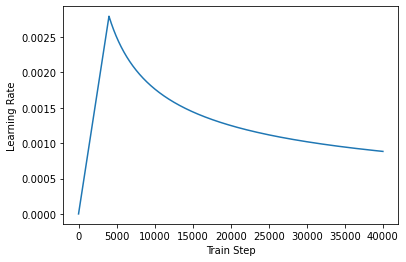

In [13]:
hand_size = 7
ht = HandTransformer(hand_size=hand_size, num_layers=2, d_model=32, num_heads=4, dff=32)

In [14]:
n = 10000
BEGIN_HAND = 52
END_HAND = 53

hands = np.array(n*(hand_size+2)*[0]).reshape(n, hand_size+2)
hands_sorted = np.array(n*(hand_size+2)*[0]).reshape(n, hand_size+2)

for i in np.arange(n):
    hand = pydeck.deal(hand_size)
    if len(hand) < hand_size:
        #print('shuffling deck')
        pydeck = pydealer.Deck()
        pydeck.shuffle()
        hand = pydeck.deal(hand_size)
    source = list(deck.index_pyhand(hand))
    source.insert(0,BEGIN_HAND)
    source.append(END_HAND)
    hands[i] = np.array(source)
    deck.sort_pyhand(hand)
    target = list(deck.index_pyhand(hand))
    target.insert(0,BEGIN_HAND)
    target.append(END_HAND)
    hands_sorted[i] = np.array(target)


## Train the model 

Now we split the data into training and test, and train the model. The "labels" are the target symbols, shifted to the left. 

In [15]:
hands_train, hands_test, sorted_train, sorted_test = train_test_split(hands, hands_sorted, test_size=0.25)

source_train = hands_train
target_train = sorted_train[:,:-1]
labels_train = sorted_train[:,1:]

source_test = hands_test
target_test = sorted_test[:,:-1]
labels_test = sorted_test[:,1:]

ht.transformer.fit((source_train, target_train), labels_train, epochs=30, batch_size=64, verbose=1)


Epoch 1/30
118/118 [==============================] - 15s 36ms/step - loss: 4.1800 - masked_accuracy: 0.0616
Epoch 2/30
118/118 [==============================] - 5s 42ms/step - loss: 3.6504 - masked_accuracy: 0.1510
Epoch 3/30
118/118 [==============================] - 5s 44ms/step - loss: 3.2233 - masked_accuracy: 0.1790
Epoch 4/30
118/118 [==============================] - 5s 44ms/step - loss: 2.7622 - masked_accuracy: 0.2473
Epoch 5/30
118/118 [==============================] - 5s 44ms/step - loss: 2.2435 - masked_accuracy: 0.3892
Epoch 6/30
118/118 [==============================] - 5s 41ms/step - loss: 1.6075 - masked_accuracy: 0.6081
Epoch 7/30
118/118 [==============================] - 5s 41ms/step - loss: 1.0270 - masked_accuracy: 0.7673
Epoch 8/30
118/118 [==============================] - 5s 44ms/step - loss: 0.7027 - masked_accuracy: 0.8349
Epoch 9/30
118/118 [==============================] - 5s 44ms/step - loss: 0.5305 - masked_accuracy: 0.8677
Epoch 10/30
118/118 [======

## Sort test data

Finally apply the model by sorting the test data, and displaying a few of the results. To symbols are decode 
one-by-one, taking the most probable prediction at each step. 

In [16]:
n = len(source_test)
output = np.zeros(n*(hand_size+2), dtype=int).reshape(n,hand_size+2)
output[:,0] = BEGIN_HAND
for i in range(hand_size+1):
    predictions = ht.transformer((source_test, output), training=False)
    predictions = predictions[:, i, :]
    predicted_id = tf.argmax(predictions, axis=-1)
    output[:,i+1] = predicted_id


In [17]:
acc = (np.sum(output[:,1:] == labels_test))/np.prod(labels_test.shape)
print('per-card accuracy: %.2f%%' % (100*acc))


per-card accuracy: 92.69%


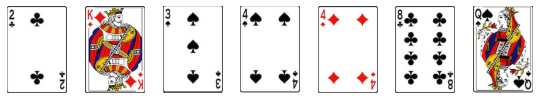

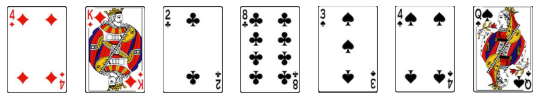

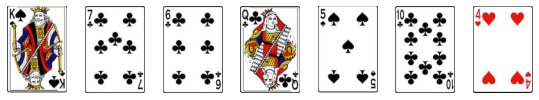

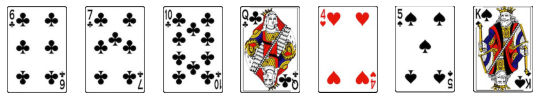

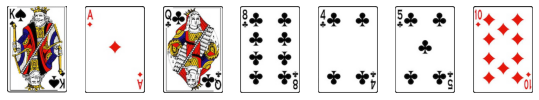

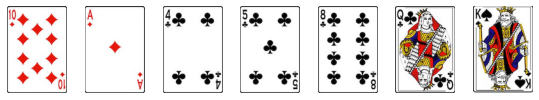

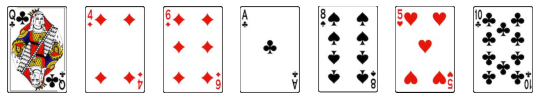

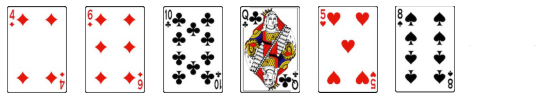

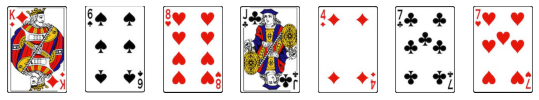

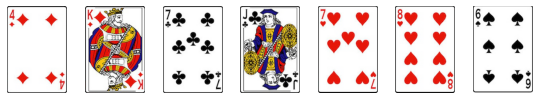

In [18]:
for i in range(5):
    j = np.random.choice(range(len(output)))
    deck.show_hand(source_test[j,1:(hand_size+1)])
    deck.show_hand(output[j,1:(hand_size+1)])
    print('\n')


The accuracy is high, but it's not perfect. If you run enough examples, you'll see some interesting errors. How would you constrain the decoder to do a better job?